## Kaggle Dataset source: https://www.kaggle.com/datasets/ryanmouton/ohiot1dm/data

In [1]:
#  Path to OhioT1DM_Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ryanmouton/ohiot1dm")

print("Path to dataset files:", path)

100%|██████████| 2.22M/2.22M [00:00<00:00, 163MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ryanmouton/ohiot1dm/versions/1


In [2]:
# Import necessary packages
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [3]:
# Directory containing the XML files
data_dir = '/content/OhioT1DM_Dataset'  # Replace with the correct directory path
train_files = glob.glob(os.path.join(data_dir, '*-training.xml'))
test_files = glob.glob(os.path.join(data_dir, '*-testing.xml'))

def parse_xml(file_path):
    """
    Parse the XML file to extract glucose level data as a time series.
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    glucose_levels = []
    timestamps = []
    for event in root.find('glucose_level').findall('event'):
        glucose_levels.append(float(event.attrib['value']))
        timestamps.append(event.attrib['ts'])

    return glucose_levels  # Return only glucose levels for modeling

# Load training data
train_data = []
for file in train_files:
    train_data.extend(parse_xml(file))

# Load testing data
test_data = []
for file in test_files:
    test_data.extend(parse_xml(file))

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

def create_sequences(data, sequence_length=10, prediction_horizon=3):
    """
    Create input sequences and targets for a given prediction horizon.
    :param data: List or array of glucose levels.
    :param sequence_length: Number of past time steps to use as input.
    :param prediction_horizon: Number of steps ahead to predict.
    """
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length - prediction_horizon):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length + prediction_horizon - 1])
    return np.array(sequences), np.array(targets)

# Specify prediction horizons
horizons = {'15min': 3, '30min': 6, '60min': 12}

models = {}
results = {}

for name, horizon in horizons.items():
    print(f"\nTraining model for {name} prediction horizon...")

    # Create sequences for the current horizon
    train_sequences, train_targets = create_sequences(train_data, sequence_length=10, prediction_horizon=horizon)
    test_sequences, test_targets = create_sequences(test_data, sequence_length=10, prediction_horizon=horizon)

    # Reshape for GRU input
    train_sequences = train_sequences.reshape(-1, 10, 1)
    test_sequences = test_sequences.reshape(-1, 10, 1)

    # Build and compile the model
    model = Sequential([
    GRU(50, activation='tanh', return_sequences=True, input_shape=(train_sequences.shape[1], train_sequences.shape[2])),
    GRU(50, activation='tanh'),
    Dense(1)  # Predict a single value
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    model.fit(train_sequences, train_targets, epochs=20, batch_size=32, validation_split=0.2)

    # Evaluate the model
    predictions = model.predict(test_sequences)
    rmse = np.sqrt(mean_squared_error(test_targets, predictions))
    r2 = r2_score(test_targets, predictions)

    # Calculate prediction accuracy: percentage of predictions within a 10% margin of the actual value
    accuracy_threshold = 0.10  # 10%
    accurate_predictions = np.abs(predictions - test_targets) / test_targets <= accuracy_threshold
    prediction_accuracy = np.mean(accurate_predictions) * 100

    print(f"{name} Model - Test RMSE: {rmse}, R2 Score: {r2}, Prediction Accuracy: {prediction_accuracy:.2f}%")

    # Store the model and results
    models[name] = model
    results[name] = {'rmse': rmse, 'r2': r2, 'accuracy': prediction_accuracy}


Training model for 15min prediction horizon...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 19554.7754 - mae: 125.7021 - val_loss: 13524.7500 - val_mae: 98.6917
Epoch 2/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 6438.6431 - mae: 60.8920 - val_loss: 5430.0347 - val_mae: 54.3223
Epoch 3/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2294.8862 - mae: 29.5136 - val_loss: 2184.3860 - val_mae: 29.8222
Epoch 4/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 960.6342 - mae: 17.2937 - val_loss: 970.6479 - val_mae: 19.6689
Epoch 5/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 513.8856 - mae: 12.7310 - val_loss: 450.8497 - val_mae: 12.4319
Epoch 6/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 365.3641 - mae: 10.9750 - val_loss: 286.7099 - val_mae: 10.4527
Epoch 7/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 291.6880 - mae: 10.2532 - val_loss: 232.3978 - val_mae: 9.5883
Epoch 8/20
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 261.2210 - mae: 9.8484 - val_loss: 201.6536 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1731/1731 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 19404.1914 - mae: 125.1806 - val_loss: 13466.7168 - val_mae: 98.4307
Epoch 2/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 6497.6924 - mae: 62.2658 - val_loss: 6373.5864 - val_mae: 64.7759
Epoch 3/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2934.8669 - mae: 38.6023 - val_loss: 2555.0752 - val_mae: 35.1870
Epoch 4/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1280.3083 - mae: 23.1678 - val_loss: 1226.5941 - val_mae: 23.1395
Epoch 5/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 858.7612 - mae: 19.2101 - val_loss: 747.0438 - val_mae: 17.9995
Epoch 6/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 681.4156 - mae: 17.4506 - val_loss: 550.8688 - val_mae: 15.5040
Epoch 7/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 651.1625 - mae: 17.0745 - val_loss: 535.5514 - val_mae: 15.8103
Epoch 8/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 621.0187 - mae: 16.7874 - val_loss: 467.0973 - val_mae:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1731/1731 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 19540.9023 - mae: 125.6553 - val_loss: 13501.1797 - val_mae: 98.5853
Epoch 2/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 6472.3560 - mae: 62.0643 - val_loss: 6352.9385 - val_mae: 64.6720
Epoch 3/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 3330.0896 - mae: 43.4386 - val_loss: 3179.2478 - val_mae: 42.5105
Epoch 4/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2001.6783 - mae: 32.6450 - val_loss: 2045.5398 - val_mae: 34.5096
Epoch 5/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1630.0254 - mae: 29.5083 - val_loss: 1517.7285 - val_mae: 29.2342
Epoch 6/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1529.0634 - mae: 28.5632 - val_loss: 1365.7327 - val_mae: 27.5815
Epoch 7/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1445.8530 - mae: 27.9795 - val_loss: 1241.8604 - val_mae: 26.3412
Epoch 8/20
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1423.9827 - mae: 27.6302 - val_loss: 1297.0955 - 


Processing test data from 559-ws-testing...
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15min Horizon - RMSE for 559-ws-testing: 14.31


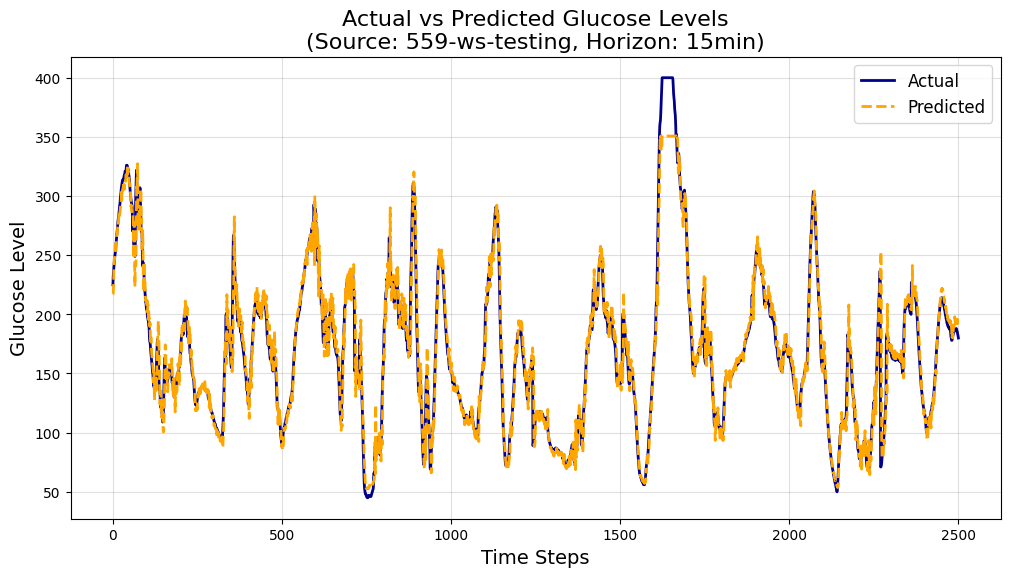

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - RMSE for 559-ws-testing: 23.01


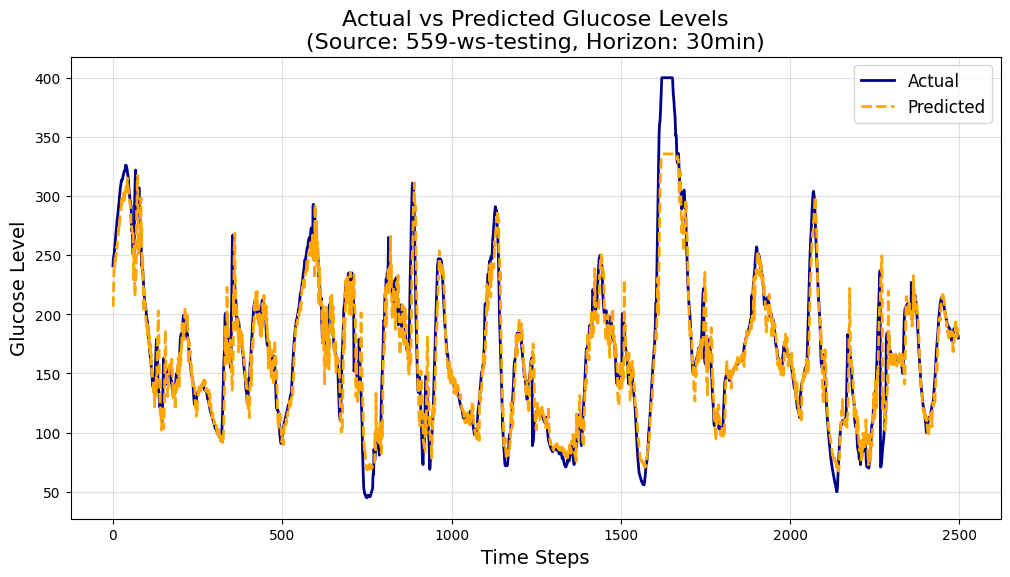

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60min Horizon - RMSE for 559-ws-testing: 38.42


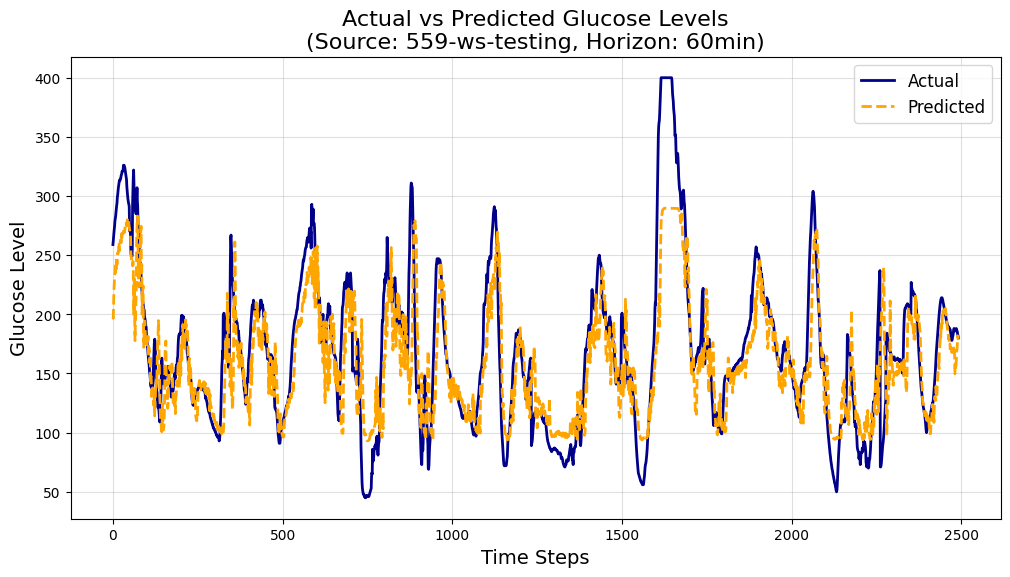


Processing test data from 570-ws-testing...
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - RMSE for 570-ws-testing: 10.30


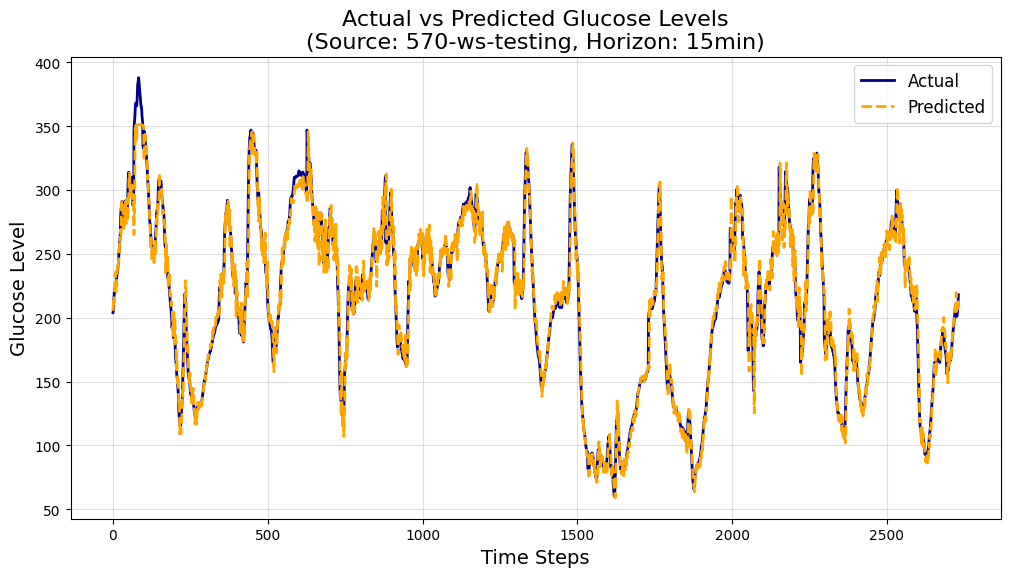

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - RMSE for 570-ws-testing: 18.89


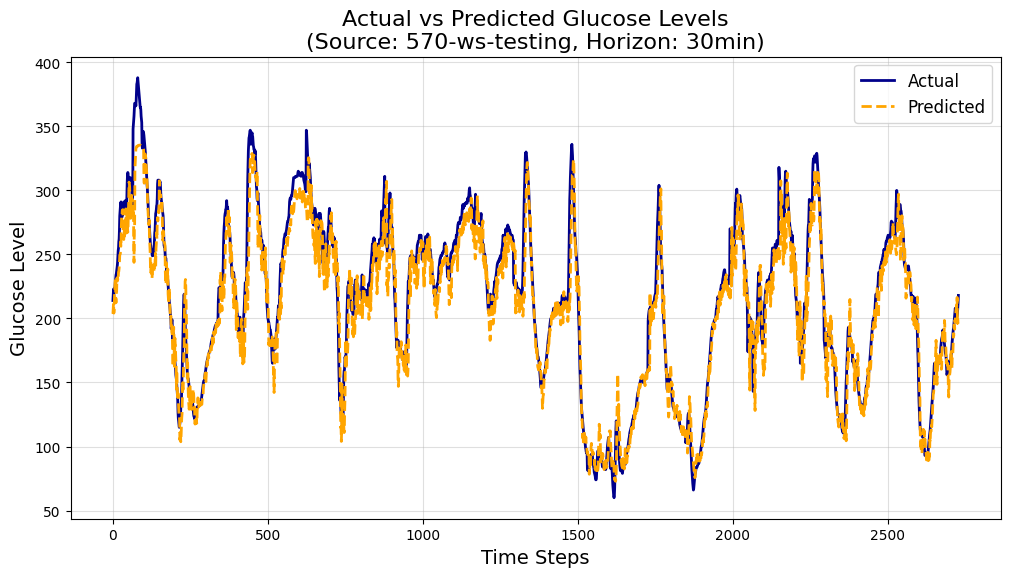

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - RMSE for 570-ws-testing: 36.45


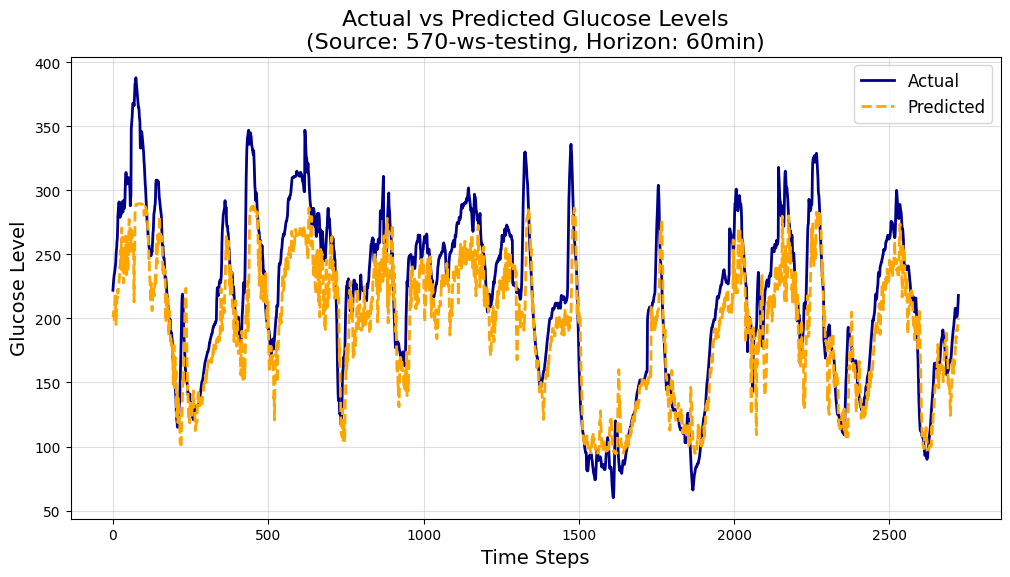


Processing test data from 563-ws-testing...
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - RMSE for 563-ws-testing: 12.51


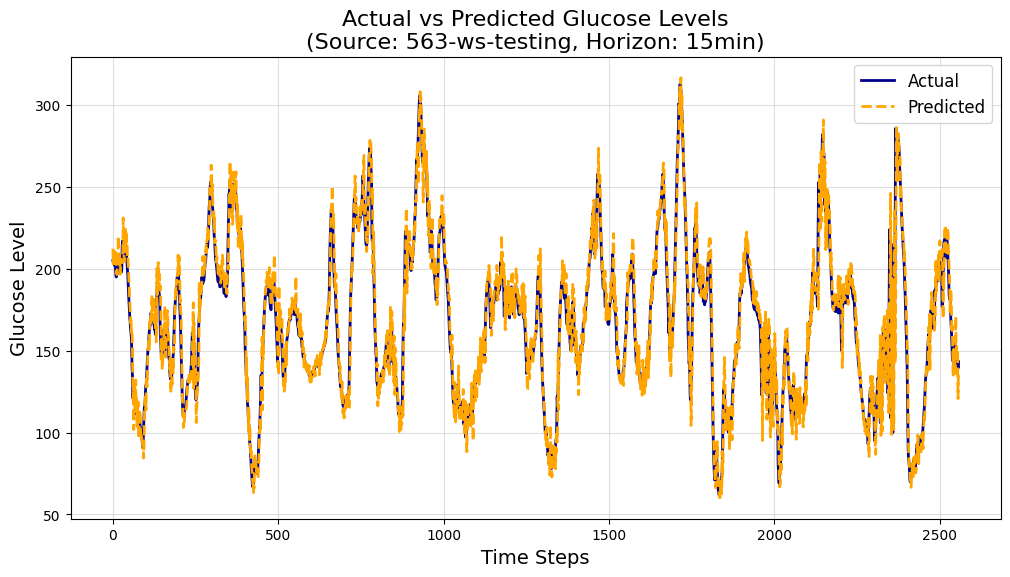

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - RMSE for 563-ws-testing: 17.86


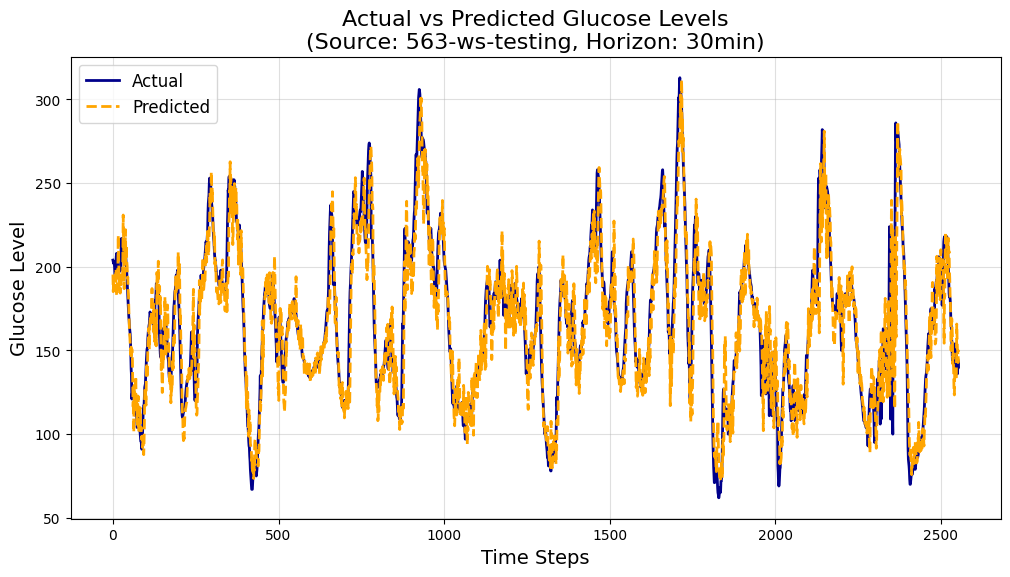

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - RMSE for 563-ws-testing: 30.28


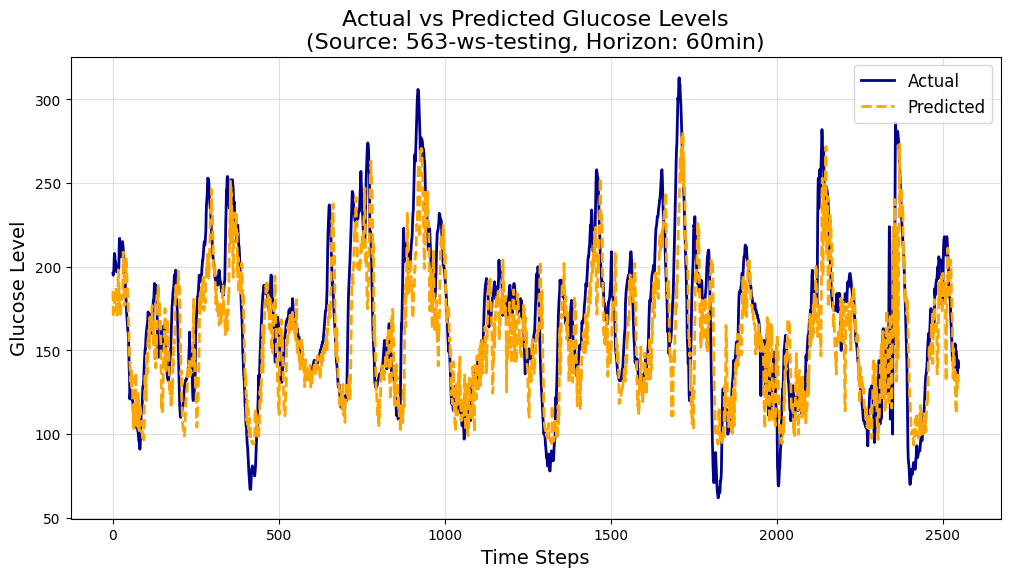


Processing test data from 588-ws-testing...
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - RMSE for 588-ws-testing: 11.27


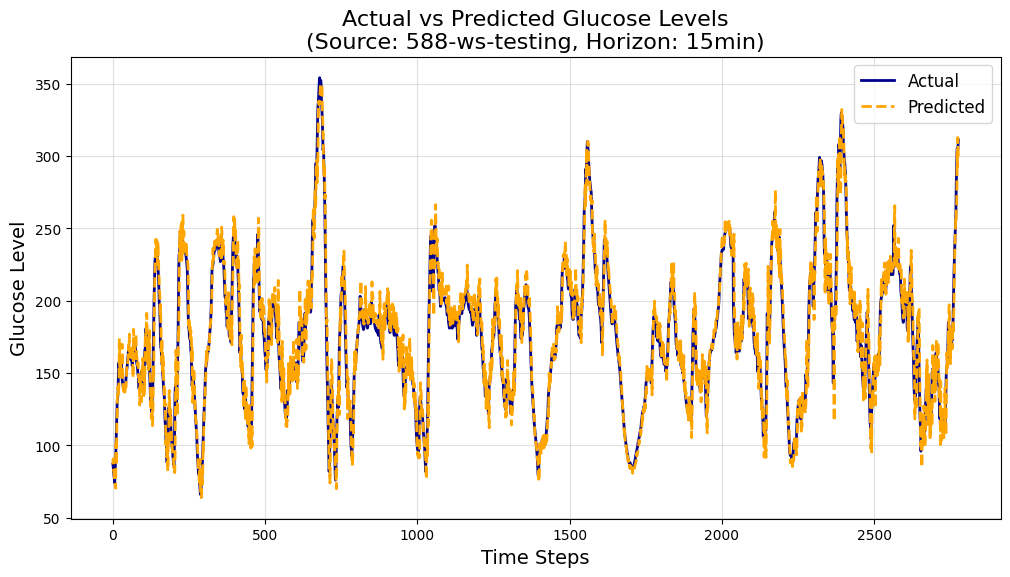

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - RMSE for 588-ws-testing: 18.94


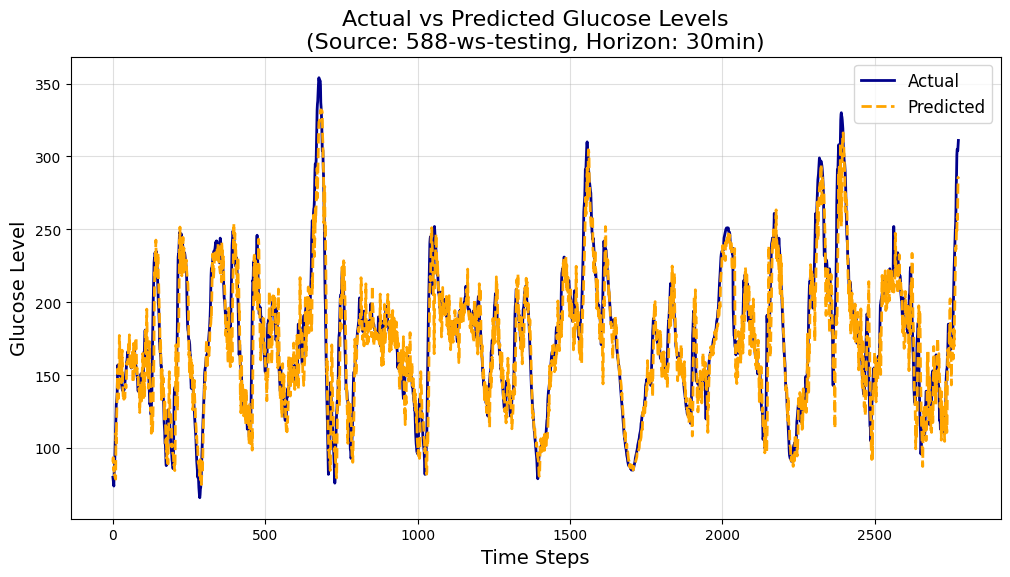

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - RMSE for 588-ws-testing: 33.53


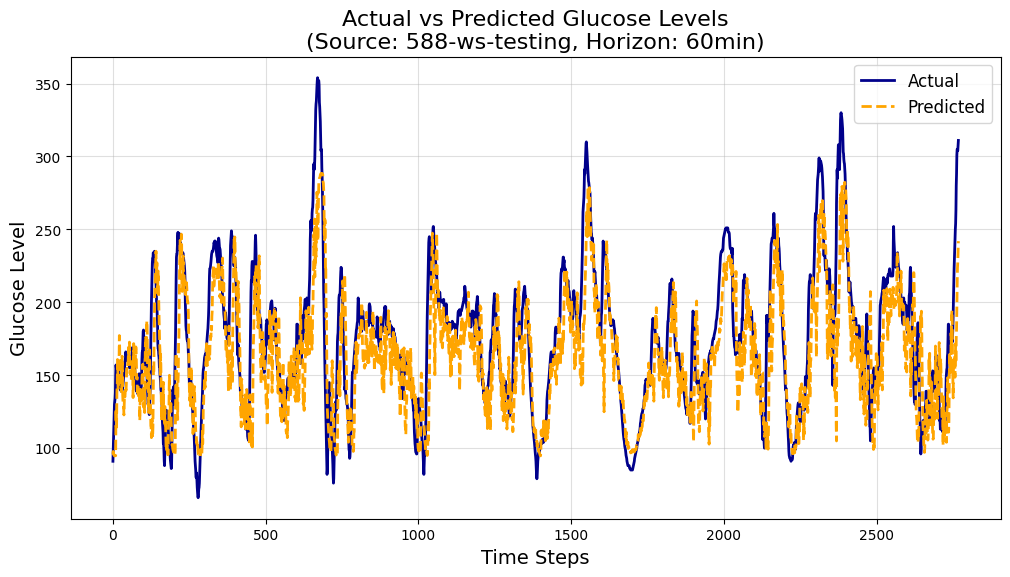


Processing test data from 591-ws-testing...
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - RMSE for 591-ws-testing: 13.28


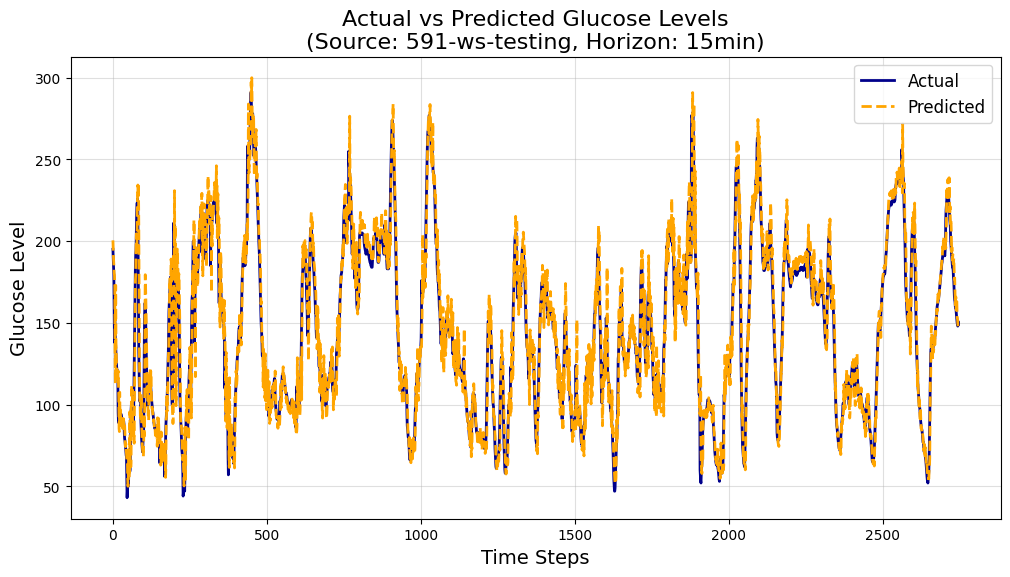

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - RMSE for 591-ws-testing: 21.27


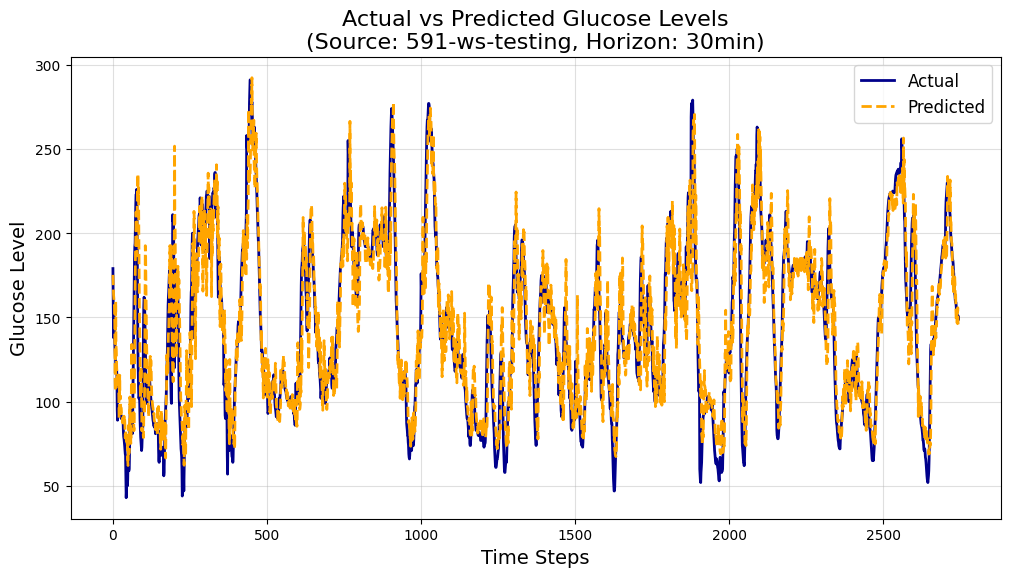

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - RMSE for 591-ws-testing: 33.34


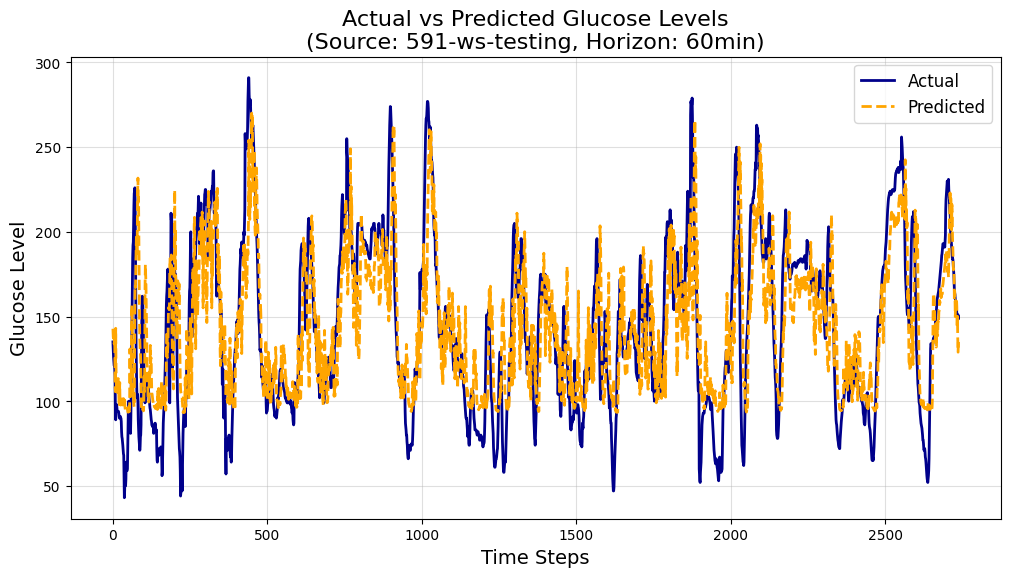


Processing test data from 575-ws-testing...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - RMSE for 575-ws-testing: 14.29


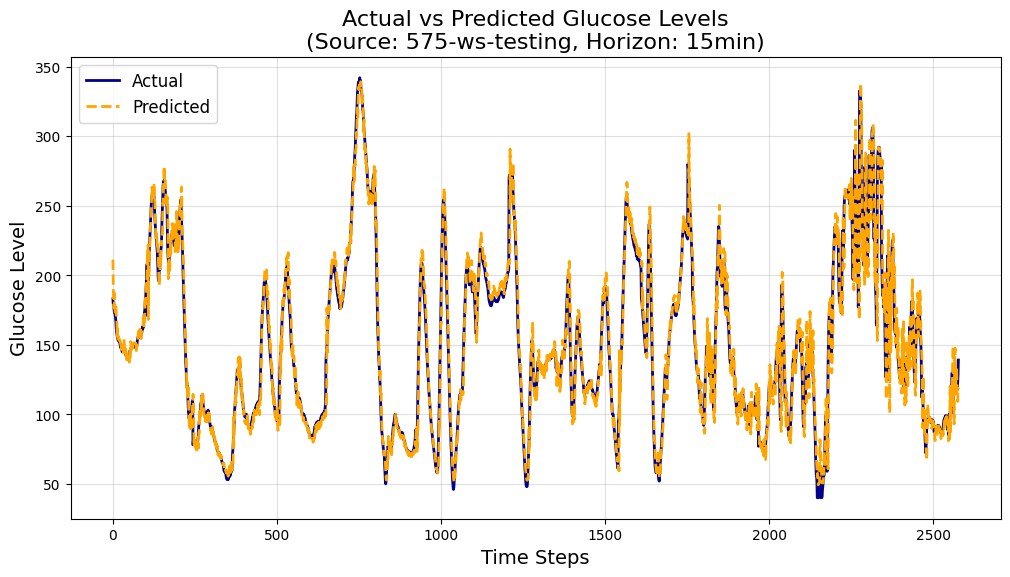

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - RMSE for 575-ws-testing: 22.60


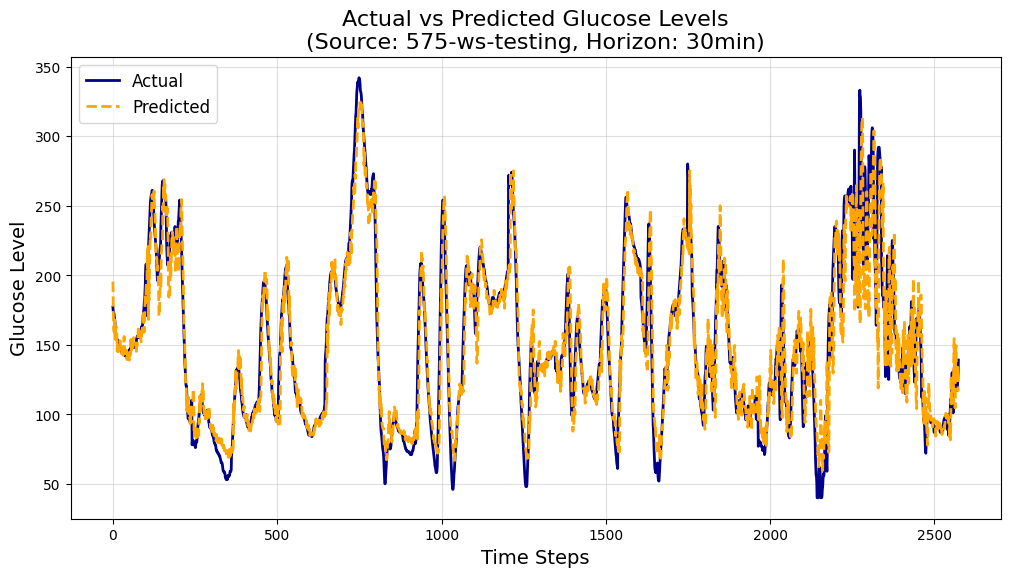

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - RMSE for 575-ws-testing: 36.15


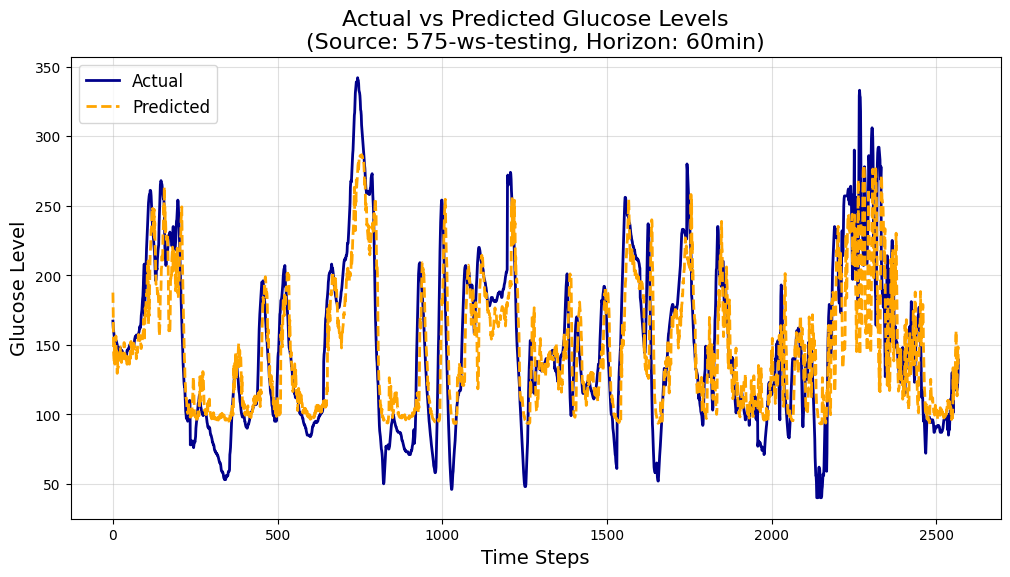

In [5]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to load data from XML files
def load_data_from_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract glucose levels
    glucose_levels = []
    for event in root.find("glucose_level"):
        glucose_levels.append(float(event.attrib["value"]))

    # Get source label (file name without extension)
    file_name = os.path.basename(file_path).split(".")[0]

    return glucose_levels, file_name

# Function to plot actual vs predicted glucose levels
def plot_actual_vs_predicted(test_targets, predictions, source, horizon_name):
    plt.figure(figsize=(12, 6))

    # Plot actual values
    plt.plot(test_targets, label='Actual', color='darkblue', linewidth=2)

    # Plot predicted values
    plt.plot(predictions, label='Predicted', color='orange', linestyle='--', linewidth=2)

    # Add title, labels, and legend
    plt.title(f'Actual vs Predicted Glucose Levels\n(Source: {source}, Horizon: {horizon_name})', fontsize=16)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Glucose Level', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.4)
    plt.show()

# Directory containing the XML files
data_directory = "./OhioT1DM_Dataset/"
test_data_by_source = {}

# Load all test files and group by source
for file_name in os.listdir(data_directory):
    if file_name.endswith("-ws-testing.xml"):
        file_path = os.path.join(data_directory, file_name)
        glucose_levels, source_label = load_data_from_xml(file_path)
        test_data_by_source[source_label] = glucose_levels

# Loop through each test source
for source, test_data in test_data_by_source.items():
    print(f"\nProcessing test data from {source}...")

    for horizon_name, horizon in horizons.items():
        # Prepare sequences and reshape for the current horizon
        test_sequences, test_targets = create_sequences(test_data, sequence_length=10, prediction_horizon=horizon)
        test_sequences = test_sequences.reshape(-1, 10, 1)

        # Make predictions
        predictions = models[horizon_name].predict(test_sequences)

        # Calculate RMSE for reference
        rmse = np.sqrt(mean_squared_error(test_targets, predictions))
        print(f"{horizon_name} Horizon - RMSE for {source}: {rmse:.2f}")

        # Plot actual vs predicted
        plot_actual_vs_predicted(test_targets, predictions, source, horizon_name)

In [6]:
def classify_glucose(value):
    """
    Classify the glucose level based on the given fasting blood sugar thresholds.

    Categories:
    - Too Low (Hypoglycemia): Below 70 mg/dL
    - Normal (Smile): Below 100 mg/dL
    - Prediabetes (Risky): 100 mg/dL or higher

    :param value: Predicted glucose value (float)
    :return: Category (string)
    """
    if value < 70:
        return "Too Low (Hypoglycemia)"
    elif value < 100:
        return "Normal (Smile)"
    else:
        return "Prediabetes or diabetes (Risky)"

In [7]:
for source, test_data in test_data_by_source.items():
    print(f"\nProcessing test data from {source}...")

    for horizon_name, horizon in horizons.items():
        # Prepare sequences and reshape for the current horizon
        test_sequences, test_targets = create_sequences(test_data, sequence_length=10, prediction_horizon=horizon)
        test_sequences = test_sequences.reshape(-1, 10, 1)

        # Make predictions
        predictions = models[horizon_name].predict(test_sequences)

        # Classify predicted values
        predicted_classes = [classify_glucose(pred) for pred in predictions]

        # Calculate RMSE for reference
        rmse = np.sqrt(mean_squared_error(test_targets, predictions))
        print(f"{horizon_name} Horizon - RMSE for {source}: {rmse:.2f}")


Processing test data from 559-ws-testing...
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - RMSE for 559-ws-testing: 14.31
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - RMSE for 559-ws-testing: 23.01
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - RMSE for 559-ws-testing: 38.42

Processing test data from 570-ws-testing...
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - RMSE for 570-ws-testing: 10.30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30min Horizon - RMSE for 570-ws-testing: 18.89
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - RMSE for 570-ws-testing: 36.45

Processing test data from 563-ws-testing...
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - RMSE for 563-ws-testing: 12.51
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - RMSE for 563-ws-testing: 17.86
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - RMSE for 563-ws-testing: 30.28

Processing test data from 588-ws-testing...
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min H

In [8]:
from sklearn.metrics import accuracy_score

def classify_predictions_and_targets(predictions, targets):
    """
    Classify both predicted and actual glucose values.

    :param predictions: List of predicted glucose values.
    :param targets: List of actual glucose values.
    :return: Classified predictions and targets.
    """
    predicted_classes = [classify_glucose(pred) for pred in predictions]
    actual_classes = [classify_glucose(target) for target in targets]
    return predicted_classes, actual_classes

# Evaluate Classification Accuracy
for source, test_data in test_data_by_source.items():
    print(f"\nProcessing test data from {source}...")

    for horizon_name, horizon in horizons.items():
        # Prepare sequences and reshape for the current horizon
        test_sequences, test_targets = create_sequences(test_data, sequence_length=10, prediction_horizon=horizon)
        test_sequences = test_sequences.reshape(-1, 10, 1)

        # Make predictions
        predictions = models[horizon_name].predict(test_sequences).flatten()

        # Classify both predictions and actual targets
        predicted_classes, actual_classes = classify_predictions_and_targets(predictions, test_targets)

        # Calculate classification accuracy
        classification_accuracy = accuracy_score(actual_classes, predicted_classes) * 100

        # Display results
        print(f"{horizon_name} Horizon - Classification Accuracy for {source}: {classification_accuracy:.2f}%")


Processing test data from 559-ws-testing...
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - Classification Accuracy for 559-ws-testing: 96.32%
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - Classification Accuracy for 559-ws-testing: 92.43%
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - Classification Accuracy for 559-ws-testing: 88.20%

Processing test data from 570-ws-testing...
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - Classification Accuracy for 570-ws-testing: 99.12%
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - Classification Accuracy for 570-ws-testing: 97.76%
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60min Horizon - Classification Accuracy for 570-ws-testing: 95.26%

Processing test data from 563-ws-testing...
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15min Horizon - Classification Accuracy for 563-ws-testing: 97.38%
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30min Horizon - Classification Accuracy for 563-ws-testing: 96.91%
80/80 ━━━━━━━━━━━